# Complete Multimodal Document Understanding Pipeline
## NeuroKnow AI Assessment - Problem 1

**Mixed Document Types:**
- **Receipts (SROIE)** → Donut extraction
- **Tables (TableBank)** → Table Transformer + OCR

**Total: ~50 documents (40 receipts + 10 tables)**

## 1. Install Dependencies

In [ ]:
# !pip install -q transformers torch datasets Pillow sentencepiece pytesseract timm
# !apt-get install -y tesseract-ocr

: 

## 2. Setup

In [2]:
import torch
import os
import json
import time
import re
import numpy as np
from pathlib import Path
from PIL import Image
from tqdm import tqdm
from collections import defaultdict

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"🖥️  Using: {device}")
if device == "cuda":
    print(f"GPU: {torch.cuda.get_device_name(0)}")

🖥️  Using: cuda
GPU: Tesla T4


## 3. Upload SROIE Dataset
⬆️ **Upload the `ICDAR-2019-SROIE` folder** to Colab (left sidebar → Files → Upload)

## 4. Load Models

In [ ]:
from transformers import (
    DonutProcessor,
    VisionEncoderDecoderModel,
    AutoImageProcessor,
    TableTransformerForObjectDetection
)
import pytesseract

print("Loading models...\n")

# Receipt Extractor (Donut)
print("1️⃣  Loading Donut for receipts...")
receipt_processor = DonutProcessor.from_pretrained("philschmid/donut-base-sroie")
receipt_model = VisionEncoderDecoderModel.from_pretrained("philschmid/donut-base-sroie")
receipt_model.to(device)
receipt_model.eval()

# Table Detection
print("2️⃣  Loading Table Transformer (detection)...")
table_detector = AutoImageProcessor.from_pretrained("microsoft/table-transformer-detection")
table_model = TableTransformerForObjectDetection.from_pretrained("microsoft/table-transformer-detection")
table_model.to(device)
table_model.eval()

# Table Structure
print("3️⃣  Loading Table Transformer (structure)...")
structure_processor = AutoImageProcessor.from_pretrained("microsoft/table-transformer-structure-recognition")
structure_model = TableTransformerForObjectDetection.from_pretrained("microsoft/table-transformer-structure-recognition")
structure_model.to(device)
structure_model.eval()

print("\n✅ All models loaded successfully!")

Loading models...

1️⃣  Loading Donut for receipts...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/361 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


tokenizer_config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/1.30M [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/257 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/485 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/809M [00:00<?, ?B/s]

2️⃣  Loading Table Transformer (detection)...


model.safetensors:   0%|          | 0.00/809M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/273 [00:00<?, ?B/s]

The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/115M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/46.8M [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:2446: UserWarning: for conv1.weight: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pass `assign=True` to assign items in the state dictionary to their corresponding key in the module instead of copying them in place?)
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:2446: UserWarning: for bn1.weight: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pass `assign=True` to assign items in the state dictionary to their corresponding key in the module instead of copying them in place?)
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:2446: UserWarning: for bn1.bias: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pas

3️⃣  Loading Table Transformer (structure)...


preprocessor_config.json:   0%|          | 0.00/274 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/115M [00:00<?, ?B/s]

Some weights of the model checkpoint at microsoft/table-transformer-structure-recognition were not used when initializing TableTransformerForObjectDetection: ['model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing TableTransformerForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TableTransformerForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).



✅ All models loaded successfully!


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 5. Define Extraction Functions

In [6]:
def extract_receipt(image):
    """Extract key-value pairs from receipt using Donut"""
    pixel_values = receipt_processor(image, return_tensors="pt").pixel_values
    decoder_input_ids = receipt_processor.tokenizer("<s>", add_special_tokens=False, return_tensors="pt").input_ids

    start = time.time()
    with torch.no_grad():
        outputs = receipt_model.generate(
            pixel_values.to(device),
            decoder_input_ids=decoder_input_ids.to(device),
            max_length=receipt_model.decoder.config.max_position_embeddings,
            early_stopping=True,
            pad_token_id=receipt_processor.tokenizer.pad_token_id,
            eos_token_id=receipt_processor.tokenizer.eos_token_id,
            use_cache=True,
            num_beams=1,
            bad_words_ids=[[receipt_processor.tokenizer.unk_token_id]],
            return_dict_in_generate=True,
        )

    inference_time = time.time() - start
    prediction = receipt_processor.batch_decode(outputs.sequences)[0]
    prediction = receipt_processor.token2json(prediction)

    return prediction, inference_time


def detect_table(image):
    """Detect if image contains table"""
    inputs = table_detector(images=image, return_tensors="pt")
    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        outputs = table_model(**inputs)

    target_sizes = torch.tensor([image.size[::-1]])
    results = table_detector.post_process_object_detection(outputs, threshold=0.7, target_sizes=target_sizes)[0]

    return len(results['scores']) > 0


def extract_table_structure(image):
    """Extract table rows and columns"""
    inputs = structure_processor(images=image, return_tensors="pt")
    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        outputs = structure_model(**inputs)

    target_sizes = torch.tensor([image.size[::-1]])
    results = structure_processor.post_process_object_detection(outputs, threshold=0.5, target_sizes=target_sizes)[0]

    id2label = structure_model.config.id2label
    rows, cols = [], []

    for score, label, box in zip(results['scores'], results['labels'], results['boxes']):
        element = id2label[label.item()]
        if 'row' in element.lower():
            rows.append(box.tolist())
        elif 'column' in element.lower():
            cols.append(box.tolist())

    return rows, cols


def ocr_cell(image, bbox):
    """Extract text from cell using OCR"""
    x1, y1, x2, y2 = map(int, bbox)
    x1, y1 = max(0, x1), max(0, y1)
    x2, y2 = min(image.width, x2), min(image.height, y2)

    if x2 <= x1 or y2 <= y1:
        return ""

    cropped = image.crop((x1, y1, x2, y2))
    return pytesseract.image_to_string(cropped, config='--psm 6').strip()


def extract_table(image):
    """Full table extraction pipeline"""
    start = time.time()

    has_table = detect_table(image)
    if not has_table:
        return {'has_table': False, 'data': None, 'num_rows': 0, 'num_columns': 0}, time.time() - start

    rows, cols = extract_table_structure(image)

    # Extract cell content
    table_data = []
    for row_bbox in rows:
        row_data = []
        for col_bbox in cols:
            cell_bbox = [
                max(row_bbox[0], col_bbox[0]),
                max(row_bbox[1], col_bbox[1]),
                min(row_bbox[2], col_bbox[2]),
                min(row_bbox[3], col_bbox[3])
            ]
            text = ocr_cell(image, cell_bbox)
            row_data.append(text)
        if row_data:
            table_data.append(row_data)

    return {
        'has_table': True,
        'num_rows': len(rows),
        'num_columns': len(cols),
        'data': table_data
    }, time.time() - start


def normalize_text(text):
    """Normalize text for comparison"""
    text = str(text).strip().lower()
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\s+', ' ', text)
    return text

print("✅ Functions defined")

✅ Functions defined


## 6. Load Datasets

In [5]:
# Load SROIE receipts
print("Loading SROIE receipts...")
data_dir = Path("/content/drive/MyDrive/my_Data")
img_dir = data_dir / "img"
key_dir = data_dir / "key"

receipt_samples = []
for json_file in key_dir.glob("*.json"):
    img_file = img_dir / f"{json_file.stem}.jpg"
    if img_file.exists():
        with open(json_file, 'r') as f:
            ground_truth = json.load(f)
        receipt_samples.append({
            'image_path': str(img_file),
            'ground_truth': ground_truth,
            'filename': json_file.stem,
            'type': 'receipt'
        })

# Sample 40 receipts
np.random.seed(42)
indices = np.random.permutation(len(receipt_samples))[:40]
receipt_samples = [receipt_samples[i] for i in indices]

print(f"✅ Loaded {len(receipt_samples)} receipt samples")

Loading SROIE receipts...
✅ Loaded 40 receipt samples


In [8]:
# Load table images
print("Looking for table images in 'table_samples/' folder...\n")

# Create directory
!mkdir -p table_samples

# Load all images from table_samples folder
import glob

table_samples = []
table_files = glob.glob("/content/drive/MyDrive/images/*.jpg")

for img_path in sorted(set(table_files)):
    filename = Path(img_path).stem
    table_samples.append({
        'image_path': img_path,
        'filename': filename,
        'type': 'table'
    })
    print(f"  Found: {filename}")

if len(table_samples) == 0:
    print("⚠️  No table images found.")
    print("📤 Please upload 5-10 table images to the 'table_samples/' folder.")
    print("   You can screenshot tables from PDFs, Wikipedia, etc.")
else:
    print(f"\n✅ Loaded {len(table_samples)} table samples")

Looking for table images in 'table_samples/' folder...

  Found: 1
  Found: 10
  Found: 2
  Found: 3
  Found: 4
  Found: 5
  Found: 6
  Found: 8
  Found: 9

✅ Loaded 9 table samples


In [9]:
# Combine all samples
all_samples = receipt_samples + table_samples
print(f"\n📊 Total samples: {len(all_samples)}")
print(f"   - Receipts: {len(receipt_samples)}")
print(f"   - Tables: {len(table_samples)}")


📊 Total samples: 49
   - Receipts: 40
   - Tables: 9


## 7. Run Evaluation

In [10]:
results = []
FIELDS = ['company', 'date', 'address', 'total']

receipt_stats = defaultdict(lambda: {'correct': 0, 'total': 0})
table_stats = {'detected': 0, 'total': 0, 'rows': [], 'cols': []}
total_time = 0

print("Processing documents...\n")

for sample in tqdm(all_samples):
    try:
        image = Image.open(sample['image_path']).convert('RGB')

        if sample['type'] == 'receipt':
            # Extract receipt
            extraction, inf_time = extract_receipt(image)
            total_time += inf_time

            # Evaluate
            correct = 0
            for field in FIELDS:
                pred = normalize_text(extraction.get(field, ""))
                gt = normalize_text(sample['ground_truth'].get(field, ""))
                if pred == gt:
                    correct += 1
                    receipt_stats[field]['correct'] += 1
                receipt_stats[field]['total'] += 1

            results.append({
                'filename': sample['filename'],
                'type': 'receipt',
                'extraction': extraction,
                'ground_truth': sample['ground_truth'],
                'correct': correct,
                'total': len(FIELDS),
                'accuracy': (correct / len(FIELDS)) * 100,
                'time': inf_time
            })

        else:  # table
            # Extract table
            extraction, inf_time = extract_table(image)
            total_time += inf_time

            table_stats['total'] += 1
            if extraction['has_table']:
                table_stats['detected'] += 1
                table_stats['rows'].append(extraction['num_rows'])
                table_stats['cols'].append(extraction['num_columns'])

            results.append({
                'filename': sample['filename'],
                'type': 'table',
                'has_table': extraction['has_table'],
                'num_rows': extraction['num_rows'],
                'num_columns': extraction['num_columns'],
                'data': extraction['data'][:3] if extraction['data'] else None,
                'time': inf_time
            })

    except Exception as e:
        print(f"\nError: {sample['filename']}: {e}")

print("\n✅ Processing complete!")

Processing documents...



100%|██████████| 49/49 [01:18<00:00,  1.60s/it]


✅ Processing complete!


## 8. Display Results

In [11]:
receipt_results = [r for r in results if r['type'] == 'receipt']
table_results = [r for r in results if r['type'] == 'table']

print("="*80)
print("EVALUATION REPORT - Multimodal Document Understanding")
print("="*80)

print(f"\n📊 Overall Statistics:")
print(f"  Total Documents: {len(results)}")
print(f"    - Receipts: {len(receipt_results)}")
print(f"    - Tables: {len(table_results)}")
print(f"  Avg Processing Time: {total_time / len(results):.3f}s per document")

# Receipt metrics
if receipt_results:
    total_correct = sum(r['correct'] for r in receipt_results)
    total_fields = sum(r['total'] for r in receipt_results)
    overall_acc = (total_correct / total_fields * 100) if total_fields > 0 else 0

    print(f"\n📄 Receipt Extraction (Donut):")
    print(f"  Overall Accuracy: {overall_acc:.2f}%")
    print(f"  Field-Level Accuracy:")
    for field, stats in receipt_stats.items():
        acc = (stats['correct'] / stats['total'] * 100) if stats['total'] > 0 else 0
        print(f"    • {field:12s}: {acc:6.2f}%  ({stats['correct']}/{stats['total']})")

# Table metrics
if table_results:
    detection_rate = (table_stats['detected'] / table_stats['total'] * 100) if table_stats['total'] > 0 else 0

    print(f"\n📊 Table Extraction (Table Transformer + OCR):")
    print(f"  Detection Rate: {detection_rate:.2f}%  ({table_stats['detected']}/{table_stats['total']})")

    if table_stats['rows']:
        print(f"  Avg Rows Detected: {np.mean(table_stats['rows']):.1f}")
        print(f"  Avg Columns Detected: {np.mean(table_stats['cols']):.1f}")

print("\n" + "="*80)

EVALUATION REPORT - Multimodal Document Understanding

📊 Overall Statistics:
  Total Documents: 49
    - Receipts: 40
    - Tables: 9
  Avg Processing Time: 0.999s per document

📄 Receipt Extraction (Donut):
  Overall Accuracy: 61.88%
  Field-Level Accuracy:
    • company     :  55.00%  (22/40)
    • date        :  65.00%  (26/40)
    • address     :  45.00%  (18/40)
    • total       :  82.50%  (33/40)

📊 Table Extraction (Table Transformer + OCR):
  Detection Rate: 100.00%  (9/9)
  Avg Rows Detected: 4.8
  Avg Columns Detected: 4.7



## 9. Save Results

In [12]:
# Save to JSON
output = {
    'total_documents': len(results),
    'receipt_accuracy': overall_acc if receipt_results else 0,
    'table_detection_rate': detection_rate if table_results else 0,
    'results': results
}

with open('evaluation_results.json', 'w') as f:
    json.dump(output, f, indent=2)

print("✅ Results saved to evaluation_results.json")

# Download
from google.colab import files
files.download('evaluation_results.json')

✅ Results saved to evaluation_results.json


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## 10. Show Sample Results


📄 RECEIPT EXAMPLES:

Receipt 1: 505
Accuracy: 0%

Extracted:
  total: 20.80
  date: 10/07/2018
  company: AIK HUAT HARDWARE ENTERPRISI (SETIA ALAM) SDN BHD
  address: NO. 17-G, JALAN SETIA INDAH (X) U132J, SETIA ALAM, SEKSYEN U13, KUJITO SHAH ALAM,



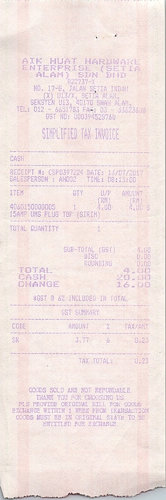


Receipt 2: 055
Accuracy: 25%

Extracted:
  total: $8.20



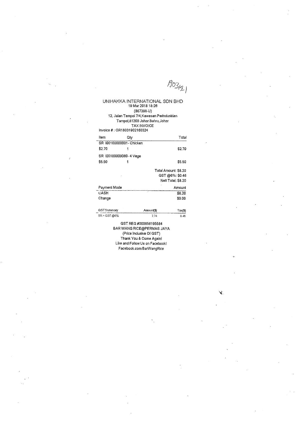


Receipt 3: 602
Accuracy: 100%

Extracted:
  total: 87.45
  date: 20/04/2018
  company: KEDAI PAPAN YEW CHUAN
  address: LOT 276 JALAN BANTING 43800 DENGKIL, SELANGOR



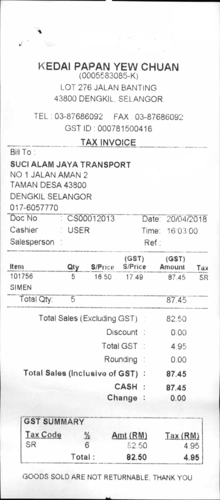



📊 TABLE EXAMPLES:

Table 1: 1
Detected: True
Rows: 11, Columns: 4

First few rows:
  ['John Henry', 'Democratic-Republican', '| nal', 'nie']
  ['Samuel Adams', 'Democratic-Republican', '| nal', 'nie']
  ['Aaron Burr', 'Democratic-Republican', 'Dna!', 'nie']



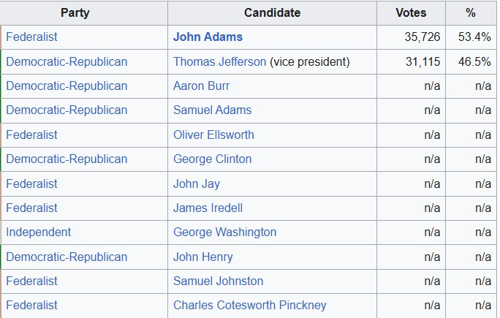


Table 2: 10
Detected: True
Rows: 3, Columns: 4

First few rows:
  ['Roger Babson/Edgar Moorman [wa]', 'Prohibition', '57,903', '0.12%']
  ['| Norman Thomas/Maynard C. Krueger', 'Socialist', '116,599', '0.23%']
  ['Earl Browder/James W. Ford', 'Communist.', 'A8 557', '0 10%']



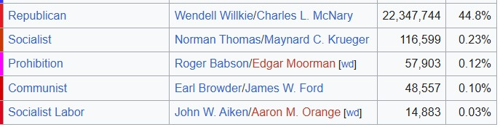


Table 3: 2
Detected: True
Rows: 2, Columns: 5

First few rows:
  ['| Thomas Jefferson/Aaron Burr', 'ycratic-Republican', '| 41,330 |', '61', ')cratic-Republican | Thomas Jefferson/Aaron Burr | 41,330 | 61']
  ['John Adams/Charles Cotesworth\nPinckney', 'ralist', '25,952', '38', '']



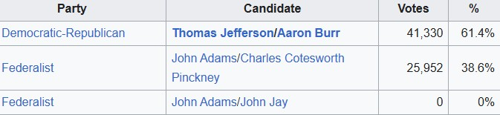

In [13]:
from IPython.display import display

# Show receipt examples
print("\n📄 RECEIPT EXAMPLES:\n")
for i, result in enumerate(receipt_results[:3]):
    print(f"{'='*60}")
    print(f"Receipt {i+1}: {result['filename']}")
    print(f"Accuracy: {result['accuracy']:.0f}%\n")
    print("Extracted:")
    for k, v in result['extraction'].items():
        print(f"  {k}: {v}")
    print()

    # Show image
    sample = next(s for s in all_samples if s['filename'] == result['filename'])
    img = Image.open(sample['image_path'])
    img.thumbnail((300, 500))
    display(img)
    print()

# Show table examples
print("\n📊 TABLE EXAMPLES:\n")
for i, result in enumerate(table_results[:3]):
    print(f"{'='*60}")
    print(f"Table {i+1}: {result['filename']}")
    print(f"Detected: {result['has_table']}")
    if result['has_table']:
        print(f"Rows: {result['num_rows']}, Columns: {result['num_columns']}")
        print(f"\nFirst few rows:")
        if result['data']:
            for row in result['data'][:3]:
                print(f"  {row}")
    print()

    # Show image
    sample = next(s for s in all_samples if s['filename'] == result['filename'])
    img = Image.open(sample['image_path'])
    img.thumbnail((500, 500))
    display(img)
    print()